## This notebook generate similarity matrices from shared embedding alignment experiments, arranges data for MUSE supervised alignment, and produces a PCA plot for one of the experiments.

In [50]:
import os

os.environ['SPECIES'] = "Mouse"
from eval.visual_utils import (get_naming_dict, filter_dataframe, FigureStyle, pval2stars, Naming_Json, export_to_excel)
njson = Naming_Json()
exp_short = njson.exp_gpt_merge0.split("_")[0]
m_param_json_file = f"/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/anal_mouse/training/{exp_short}/{njson.exp_gpt_merge0}.param_config.json"
os.environ['PARAM_JSON_FILE'] = m_param_json_file

from utils.utils import get_device, get_model, get_config
from train.common_params_funs import get_gene2idx
from utils.params import params
from eval.eval_utils import get_self_emb
from sklearn.metrics.pairwise import cosine_similarity
from eval_m.m_eval_utils import get_n_closest_tokens, reorder_symmetric_matrix, mean_and_std_of_arrays, find_rank_of_similarity, eval_simi_mat
from eval_m.m_visual_utils import plot_PCA, plot_histogram
from data_m.get_homolo_mg import get_homolo_mg
from data_m.m_data_utils import split_human_mouse_emb_and_genes, split_dict, dict_to_file, write_string_to_file, save_matrix_and_ids, load_matrix_and_ids
import numpy as np
from data.data_utils import output_emb
from eval_m.muse_utils import load_muse_result, get_gene_to_ori_case_dict, get_muse_result_uid_dir
params = params()

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse


In [51]:
config = get_config()
gene_prefix = config.gene_prefix

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse


In [52]:
# Load homolog gene list, split the ono-to-one orthologs
h2m_genes, m2h_genes, h2m_one2one, m2h_one2one = get_homolo_mg()
ratio = 0.95
m2h_one2one_9, m2h_one2one_1 = split_dict(m2h_one2one, split_ratio=ratio)
dict_to_file(m2h_one2one_9, f"{config.proj_path}/data/external/Homolo/MouseGenomeInfo/HOM_MouseHumanSequence.rpt.m2h_one2one.train.dico_{ratio}.txt", config)
dict_to_file(m2h_one2one_1, f"{config.proj_path}/data/external/Homolo/MouseGenomeInfo/HOM_MouseHumanSequence.rpt.m2h_one2one.eval.dico_{1-ratio:.2f}.txt", config)

Saved to /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse//data/external/Homolo/MouseGenomeInfo/HOM_MouseHumanSequence.rpt.m2h_one2one.train.dico_0.95.txt
Saved to /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse//data/external/Homolo/MouseGenomeInfo/HOM_MouseHumanSequence.rpt.m2h_one2one.eval.dico_0.05.txt


In [53]:
def get_gene2idx_emb(m_param_json_file, epoch=None):
    import os
    exp = os.path.basename(m_param_json_file).replace(".param_config.json", "")
    os.environ['PARAM_JSON_FILE'] = m_param_json_file
    os.environ['SPECIES'] = "Mouse"
    
    m_config = get_config()
    m_gene2idx, m_idx2gene = get_gene2idx(params.GENE_EMB_NAME)
    m_expr_emb, m_gene_id_emb = get_self_emb(m_param_json_file,
                  m_config.proj_path + f"/results/models/pretrain/{exp}/model.rank0.epoch{epoch}.pth")
    return m_gene2idx, m_idx2gene, m_expr_emb, m_gene_id_emb

In [54]:
target_gene_order_gene2idx, _ = get_gene2idx(params.GENE_EMB_NAME)
target_gene_order = list(target_gene_order_gene2idx.keys())

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Reading gene_to_idx_path /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse/data/embedding/hm_merge0_coding_gene_to_idx.json!


In [55]:
script_path = "/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/other_repos/MUSE/"
n_refinement_muse = 5
epoch = njson.epoch
num_gene_have_merged_idx = params.NUM_GENE_TO_MERGE_INDICES

In [56]:
directly_load_simi_matrix = True

In [ ]:
# Check if the similarity matrix should be directly loaded or not.
if directly_load_simi_matrix == False:
    
    # Initialize a list to store reordered similarity matrices for aggregation.
    reordered_simi_matrix_list = []
    # Iterate over three experiments to process their respective gene embeddings.
    for i in range(0,3):
        # Construct experiment key and retrieve experiment details from configuration.
        exp_key = f"exp_gpt_merge{i}"
        exp = njson.get(exp_key)
        # Extract the short form of the experiment name.
        exp_short = exp.split("_")[0]
        # Define the output directory based on the experiment.
        out_dir = f"{config.proj_path}/results/anal/{exp}"
        # Path to the mouse parameter configuration file for the current experiment.
        m_param_json_file = f"/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/anal_mouse/training/{exp_short}/{exp}.param_config.json"
        # Load gene to indices, indices to genes, expression embedding and gene embeddings from the parameter file.
        m_gene2idx, m_idx2gene, m_expr_emb, m_gene_id_emb = get_gene2idx_emb(m_param_json_file, epoch=epoch)
        # Convert embeddings to a NumPy array.
        gene_emb_npy = m_gene_id_emb.weight.detach().cpu().numpy()
    
        # Ensure the consistency between the number of embeddings and index mappings.
        assert gene_emb_npy.shape[0] == len(m_idx2gene), "gene_emb_npy.shape[0] != len(m_idx2gene)"
        # Identify genes that have merged indices.
        genes_on_the_right_original = [m_idx2gene[i] for i in range(num_gene_have_merged_idx, len(m_idx2gene))]
    
        # Separate human and mouse gene embeddings and names after a specific index (number of genes with shared emb).
        gene_emb_npy_human, gene_emb_npy_mouse, genes_human, genes_mouse = split_human_mouse_emb_and_genes(gene_emb_npy[num_gene_have_merged_idx:], genes_on_the_right_original, config, to_lower_case=True)
        
        # Output the separated human gene embeddings to a file.
        output_emb(genes_human, 
                   gene_emb_npy_human, 
                   output_file_path=f"{out_dir}/gene_emb_ori_human_unanchor_genes.epoch{epoch}.txt",
                   write_emb_dim_to_first_line=True
                  )
        # Similarly, output the mouse gene embeddings.
        output_emb(genes_mouse, 
                   gene_emb_npy_mouse, 
                   output_file_path=f"{out_dir}/gene_emb_ori_mouse_unanchor_genes.epoch{epoch}.txt",
                   write_emb_dim_to_first_line=True
                  )
        # Construct the command for supervised alignment using MUSE and write it to a file.
        cmd = f"python3 {script_path}/supervised.py --n_refinement {n_refinement_muse} --src_lang mouse --tgt_lang human --emb_dim 200 --cuda True --src_emb {out_dir}/gene_emb_ori_mouse_unanchor_genes.epoch{epoch}.txt --tgt_emb {out_dir}/gene_emb_ori_human_unanchor_genes.epoch{epoch}.txt --exp_path {out_dir} --exp_name {exp}.epoch{epoch}.muse_partial{i} --dico_train {config.proj_path}/data/external/Homolo/MouseGenomeInfo/HOM_MouseHumanSequence.rpt.m2h_one2one.train.dico_0.95.txt --dico_eval {config.proj_path}/data/external/Homolo/MouseGenomeInfo/HOM_MouseHumanSequence.rpt.m2h_one2one.eval.dico_0.05.txt"
        # Save the constructed command to a shell script file for execution.
        write_string_to_file(f"{out_dir}/{exp}.epoch{epoch}.muse_partial{i}/MUSE_cmd.sh", cmd)
    
        # Compute the cosine similarity matrix for the current set of embeddings.
        similarity_matrix = cosine_similarity(gene_emb_npy[num_gene_have_merged_idx:])
        
        # Reorder the similarity matrix to match a target gene order and add to the list.
        reordered_simi_matrix = reorder_symmetric_matrix(similarity_matrix, genes_on_the_right_original, target_gene_order)
        reordered_simi_matrix_list.append(reordered_simi_matrix)
        # Clear memory by deleting the temporary reordered similarity matrix.
        del reordered_simi_matrix
    
    # Calculate the mean and standard deviation of the aggregated reordered similarity matrices.
    reordered_simi_mean, reordered_simi_std = mean_and_std_of_arrays(reordered_simi_matrix_list)
    
    # Save the mean reordered similarity matrix along with gene order to a file.
    save_matrix_and_ids(reordered_simi_mean, 
                        target_gene_order, 
                        output_file=f"{config.proj_path}/results/anal/gpt_merged/reordered_simi_mean.epoch{epoch}.npy")


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


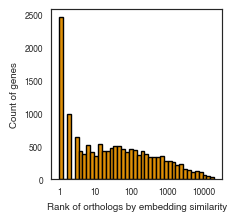

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


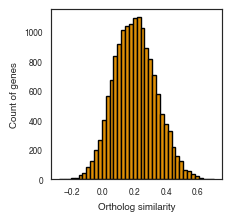

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


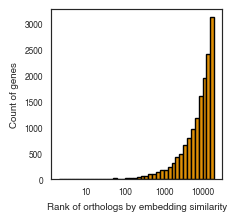

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


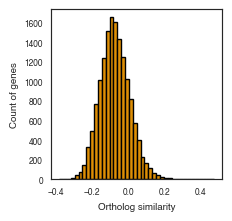

In [9]:
if directly_load_simi_matrix:
    reordered_simi_mean, target_gene_order = load_matrix_and_ids(f"{config.proj_path}/results/anal/gpt_merged/reordered_simi_mean.epoch{epoch}.npy")

reordered_simi_mean_rank_simi_results = eval_simi_mat(reordered_simi_mean, 
              target_gene_order, 
              njson, 
              config, 
              output_prefix=f"{config.proj_path}/results/anal/gpt_merged/reordered_simi_mean.epoch{epoch}.eval")

## Below load MUSE result, and take average

In [ ]:
if directly_load_simi_matrix == False:
        
    gene2idx, _ = get_gene2idx(params.GENE_EMB_NAME)
    gene_to_ori_case_dict = get_gene_to_ori_case_dict(gene2idx)
    reordered_simi_matrix_muse_list = []
    for i in range(0,3):
        exp_key = f"exp_gpt_merge{i}"
        exp = njson.get(exp_key)
        exp_short = exp.split("_")[0]
        out_dir = f"{config.proj_path}/results/anal/{exp}"
        dir_without_uid = f"{out_dir}/{exp}.epoch{epoch}.muse_partial{i}"
        muse_result_dir = get_muse_result_uid_dir(dir_without_uid)
        hm_emb, hm_gene_names, hm_token_types = load_muse_result(muse_result_dir, gene_to_ori_case_dict=gene_to_ori_case_dict)
        plot_histogram(hm_emb[np.random.choice(hm_emb.shape[0], 500, replace=False)])
        similarity_matrix = cosine_similarity(hm_emb)
        
        reordered_simi_matrix = reorder_symmetric_matrix(similarity_matrix, hm_gene_names, target_gene_order)
        reordered_simi_matrix_muse_list.append(reordered_simi_matrix)
        del reordered_simi_matrix
    
    reordered_simi_muse_mean, reordered_simi_muse_std = mean_and_std_of_arrays(reordered_simi_matrix_muse_list)
    
    save_matrix_and_ids(reordered_simi_muse_mean, 
                       target_gene_order, 
                       output_file=f"{config.proj_path}/results/anal/gpt_merged/reordered_simi_muse_mean.muse.epoch{epoch}.npy")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


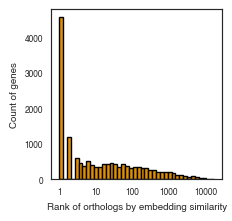

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


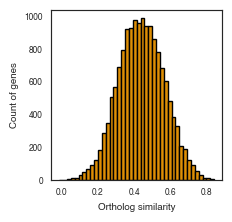

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


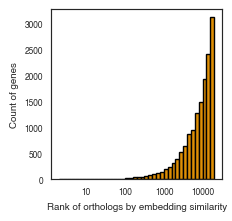

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


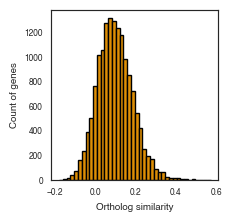

In [10]:
if directly_load_simi_matrix:
    reordered_simi_muse_mean, target_gene_order = load_matrix_and_ids(f"{config.proj_path}/results/anal/gpt_merged/reordered_simi_muse_mean.muse.epoch{epoch}.npy")

reordered_simi_muse_mean_rank_simi_results = eval_simi_mat(reordered_simi_muse_mean, 
              target_gene_order, 
              njson, 
              config, 
              output_prefix=f"{config.proj_path}/results/anal/gpt_merged/reordered_simi_muse_mean.epoch{epoch}.eval")

In [11]:
# "gpt_anchored_no_muse": shared embedding only
# "gpt_anchored_muse": shared embedding + supervised alignment
gpt_merged_rank_simi_results_dicts = {
    "gpt_anchored_no_muse": reordered_simi_mean_rank_simi_results,
    "gpt_anchored_muse": reordered_simi_muse_mean_rank_simi_results
}
import pickle
pkl_file = f"{config.proj_path}/results/anal/gpt_merged/gpt_merged_rank_simi_results_dicts.pkl"
with open(pkl_file, "wb") as f:
    pickle.dump(gpt_merged_rank_simi_results_dicts, f)

In [26]:
idx2gene_target_order = {i:target_gene_order[i] for i in range(0, len(target_gene_order))}

In [27]:
gene_types = [njson.m_label if config.gene_prefix in gene else njson.h_label for gene in idx2gene_target_order.values()]

## PCA only visualize one shared embedding experiment

In [29]:
i = 0
exp_key = f"exp_gpt_merge{i}"
exp = njson.get(exp_key)
exp_short = exp.split("_")[0]
m_param_json_file = f"/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/anal_mouse/training/{exp_short}/{exp}.param_config.json"
m_gene2idx, m_idx2gene, m_expr_emb, m_gene_id_emb = get_gene2idx_emb(m_param_json_file, epoch=epoch)
gene_emb_npy = m_gene_id_emb.weight.detach().cpu()
assert gene_emb_npy.shape[0] == len(m_idx2gene), "gene_emb_npy.shape[0] != len(m_idx2gene)"


Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Reading gene_to_idx_path /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse/data/embedding/hm_merge0_coding_gene_to_idx.json!
params.TRANSFORMER_MODEL_NAME GPT
Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Reading gene_to_idx_path /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse/data/embedding/hm_merge0_coding_gene_to_idx.json!
Model checkpoint loaded from: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse//results/models/pretrain/exp30_GPT_hm_merge0_coding/model.rank0.epoch40.pth


In [30]:
## This is for checking if the rank in the training and evaluation gene set is the same
# h2m_genes, m2h_genes, h2m_one2one, m2h_one2one = get_homolo_mg()

# m2h_one2one_train = {k:v for k, v in m2h_one2one.items() if m_gene2idx.get(f"{config.gene_prefix}{k}", 100000000) < params.NUM_GENE_TO_MERGE_INDICES}
# m2h_one2one_eval = {k:v for k, v in m2h_one2one.items() if m_gene2idx.get(f"{config.gene_prefix}{k}", 0) >= params.NUM_GENE_TO_MERGE_INDICES}
# m2h_one2one_train = {f"{config.gene_prefix}{k}": v for k, v in m2h_one2one_train.items()}
# m2h_one2one_eval = {f"{config.gene_prefix}{k}": v for k, v in m2h_one2one_eval.items()}

# similarity_matrix = cosine_similarity(gene_emb_npy)

# ranks_from_muse_eval, _ = find_rank_of_similarity(similarity_matrix, list(m_idx2gene.values()), m2h_one2one_eval)

#plot_histogram(np.log10(np.array(list(ranks_from_muse_eval.values()))))

In [48]:
njson = Naming_Json()

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


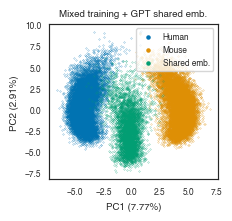

In [57]:
gene_emb_mat_pca = gene_emb_npy
original_gene_order = list(m_gene2idx.keys())

gene_types_pca = np.array([njson.m_label if config.gene_prefix in gene else njson.h_label for gene in m_idx2gene.values()])
gene_types_pca = [njson.merged_label if i < num_gene_have_merged_idx else type for i, type in enumerate(gene_types_pca)]

gene_emb_npy_selected = gene_emb_mat_pca
gene_types_pca_selected = np.array(gene_types_pca)

# gene_types_pca_selected = [f"{i} genes" for i in gene_types_pca_selected]
plot_PCA(gene_emb_npy_selected, 
         gene_types_pca_selected,
         figsize=(njson.one3rd_fig_width, njson.fig_height_a0), 
         output_file = config.proj_path + f"/results/figures_tables/emb_pcas/gpt_merged.pdf",
         legend_loc = "upper right",
         title = f"{njson.mixed_training} + {njson.anchor}"
        )